In [63]:
import logging
import math
import os

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from msig import Motif, NullModel

params = {"legend.fontsize": "xx-large", "axes.labelsize": 20}
pylab.rcParams.update(params)
logging.basicConfig(level=logging.INFO)

In [64]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

data = individual_household_electric_power_consumption.data.features
# date and time col to timestamp
data["timestamp"] = pd.to_datetime(
    data["Date"] + " " + data["Time"], format="%d/%m/%Y %H:%M:%S"
)
data = data.set_index("timestamp")
data = data.resample("1min").last().ffill()
# largest sequence without nans
data = data.loc["2008-09-01":"2008-10-24"]
labels = data[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]]
labels = labels.astype(float)
# labels = labels.map(lambda x: 1 if float(x) > 0 else 0)
data = data.drop(
    columns=["Date", "Time", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
)
data.replace("?", np.nan, inplace=True)  # missing values
data = data.astype(float)
data


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity
timestamp,,,,
2008-09-01 00:00:00,1.300,0.000,243.04,5.4
2008-09-01 00:01:00,1.282,0.000,243.30,5.2
2008-09-01 00:02:00,1.302,0.000,243.40,5.2
2008-09-01 00:03:00,1.284,0.000,243.47,5.2
2008-09-01 00:04:00,1.304,0.000,243.55,5.4
...,...,...,...,...
2008-10-24 23:55:00,0.682,0.000,243.84,2.8
2008-10-24 23:56:00,0.630,0.064,244.69,2.6
2008-10-24 23:57:00,0.620,0.080,245.20,2.6


In [65]:
sr = 1 / 60
results_path = "../results/household/" + str(sr)
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")
    os.makedirs(results_path + "/mp_indices")

In [66]:
# features = data.columns
# stats_table = pd.DataFrame()
# resids = {}

# # get the data for those features
# for data_feature in features:
#     print(data_feature)
#     time_serie = data[data_feature]
#     res = MSTL(
#         time_serie, periods=[60 * 24, 60 * 24 * 7]
#     ).fit()  # seasonal period is daily and weekly
#     resids[data_feature] = res.resid

#     var_resid = np.var(res.resid)
#     var_observed = np.var(res.observed)
#     trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
#     noise_strength = var_resid / var_observed

#     seasonal_individial_strengths = {}
#     for period in res.seasonal:
#         seasonal_individial_strengths["F_" + str(period)] = max(
#             0, 1 - (var_resid / np.var(res.seasonal[period] + res.resid))
#         )
#     seasonal_strength = max(
#         0, 1 - (var_resid / np.var(res.seasonal.sum(axis=1) + res.resid))
#     )

#     stats_df = {
#         "Feature": data_feature,
#         "F_T": round(trend_strength, 3),
#         "F_S": round(seasonal_strength, 3),
#         "F_R": round(noise_strength, 3),
#     }

#     # add individual seasonal strengths to stats_df, rounded with 3 decimals
#     for period in seasonal_individial_strengths:
#         stats_df[period] = round(seasonal_individial_strengths[period], 3)

#     stats_table = pd.concat(
#         [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
#     )

# pd.DataFrame(resids).to_csv(results_path + "/resids.csv", index=True)
# stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
# stats_table.to_csv(results_path + "/decomposition_summary.csv", index=False)
# stats_table.head().to_latex()

In [67]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
top_k_mp = 1
include = None
normalize = False
subsequence_lengths = [60, 60 * 3, 60 * 6]  # 1h, 3h, 6h

resids = pd.read_csv(results_path + "/resids.csv", index_col=0).T

# for m in subsequence_lengths:
#     mp, mp_indices = stumpy.mstump(resids.values, m, normalize=normalize)
#     np.save(
#         results_path
#         + "/mp/normalized={}_topkmp={}_m={}_multivariate.npy".format(
#             normalize, top_k_mp, m
#         ),
#         mp,
#         allow_pickle=True,
#     )
#     np.save(
#         results_path
#         + "/mp_indices/normalized={}_topkmp={}_m={}_multivariate.npy".format(
#             normalize, top_k_mp, m
#         ),
#         mp_indices,
#         allow_pickle=True,
#     )

In [68]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    k_distances,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k_distances",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        if k_distances is None:  # consider all matches
            med_dist = np.median(match_distances[1:])
        else:  # consider only the k closest matches
            med_dist = np.median(match_distances[1 : k_distances + 1])

        # np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
        if max_allowed_dist is None:
            current_data = data[dimensions]
            n_vars, n_time = current_data.shape

            # D The distance profile of `Q` with `T`. It is a 1D numpy array of size
            # `len(T)-len(Q)+1`, where `D[i]` is the distance between query `Q` and
            # `T[i : i + len(Q)]`
            D = np.empty((n_vars, n_time - m + 1))
            for i in range(n_vars):
                D[i, :] = stumpy.mass(
                    multivar_subsequence[i], current_data[i], normalize=normalize
                )
            D = np.mean(D, axis=0)
            D_copy = D.copy().astype(np.float64)
            D_copy[np.isinf(D_copy)] = np.nan
            motif_max_allowed_dist = np.nanmax(
                [np.nanmean(D_copy) - 2.0 * np.nanstd(D_copy), np.nanmin(D_copy)]
            )
        else:
            motif_max_allowed_dist = max_allowed_dist

        unified_weights = "0.33,0.33,0.33"
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / motif_max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = motif_max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(motif_max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [69]:
k_distances = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
k = None
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    X = resids.values
    mp = np.load(
        results_path
        + "/mp/normalized={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        allow_pickle=True,
    )
    mp_indices = np.load(
        results_path
        + "/mp_indices/normalized={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        allow_pickle=True,
    )

    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(
        X,
        mp,
        mp_indices,
        min_neighbors=min_neighbors,
        max_distance=max_distance,
        cutoffs=np.inf,
        max_matches=max_matches,
        max_motifs=max_motifs,
        k=k,
        include=include,
        normalize=normalize,
    )

    if len(motif_indices[0]) == 0:
        continue
    table = table_summary_motifs(
        motif_indices,
        motif_distances,
        motif_subspaces,
        X,
        k_distances,
        m,
        normalize,
        max_distance,
    )
    logging.info(
        "m:{}, #Motifs:{}, Sig:{}".format(
            m, len(motif_indices), np.sum(table["p-value"] < 0.001)
        )
    )
    # hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
    sig = (
        table["p-value"] < critical_value
        if critical_value != 0
        else table["p-value"] <= critical_value
    )
    table["Sig_Hochber"] = sig
    logging.info(
        "Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value)
    )
    mp_stats_table = (
        table
        if mp_stats_table.empty
        else pd.concat([mp_stats_table, table], ignore_index=True)
    )

    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
            normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
        ),
        index=False,
    )

INFO:root:p_value = 8.611E-209 (p_pattern = 2.430E-38)
INFO:root:p_value = 0.000E+00 (p_pattern = 2.169E-35)
INFO:root:p_value = 0.000E+00 (p_pattern = 6.216E-37)
INFO:root:p_value = 1.669E-124 (p_pattern = 3.863E-45)
INFO:root:p_value = 1.160E-103 (p_pattern = 3.421E-38)
INFO:root:p_value = 5.293E-180 (p_pattern = 1.527E-33)
INFO:root:p_value = 2.354E-79 (p_pattern = 4.332E-30)
INFO:root:p_value = 1.198E-101 (p_pattern = 4.996E-18)
INFO:root:p_value = 6.523E-229 (p_pattern = 4.361E-32)
INFO:root:p_value = 2.802E-191 (p_pattern = 7.802E-42)
INFO:root:p_value = 3.529E-94 (p_pattern = 4.958E-35)
INFO:root:p_value = 1.001E-95 (p_pattern = 1.512E-35)
INFO:root:p_value = 4.448E-125 (p_pattern = 6.980E-35)
INFO:root:p_value = 6.939E-71 (p_pattern = 2.883E-27)
INFO:root:p_value = 1.146E-151 (p_pattern = 1.573E-41)
INFO:root:p_value = 7.769E-197 (p_pattern = 4.458E-28)
INFO:root:p_value = 5.553E-133 (p_pattern = 5.767E-48)
INFO:root:p_value = 1.789E-133 (p_pattern = 3.953E-48)
INFO:root:p_valu

In [70]:
# read motifs table
mp_stats_table = pd.read_csv(
    results_path
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)

# for motif in mp_stats_table
indexes_to_remove = set()
for index, motif in mp_stats_table.iterrows():
    indexes_to_remove.update(
        [
            i
            for index in eval(motif["Indices"])
            for i in range(int(index), int(index) + int(motif["m"]))
        ]
    )

datetime_indexes_to_remove = resids.T.index[sorted(indexes_to_remove)]

residual_nomatches = resids.T.copy()
for feature in residual_nomatches.columns:
    residual_nomatches.loc[datetime_indexes_to_remove, feature] = 0
    variance_explained = 100 * (
        1
        - (
            np.mean(np.abs(residual_nomatches[feature]))
            / np.mean(np.abs(resids.T[feature]))
        )
    )
    print(f"{feature}: {variance_explained}")

Global_active_power: 97.30381053111883
Global_reactive_power: 96.63990494556802
Voltage: 97.24139695035878
Global_intensity: 97.26429727337738


In [71]:
# create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std,
# average probability +- std, average pvalue +- std)

mp_stats_table = pd.read_csv(
    results_path
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)
motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(
    columns=[
        "m",
        "#motifs",
        "avg_n_matches",
        "avg_n_features",
        "avg_probability",
        "avg_pvalue",
        "#sig_motifs(<0.01)",
        "significant",
        "#sig_hochberg",
    ]
)
for m in subsequence_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    if table.empty:
        continue
    n_motifs = table.shape[0]
    n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
    avg_n_matches = (
        round(table["#Matches"].mean(), 2),
        round(table["#Matches"].std(), 3),
    )
    avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
    avg_probability = table["P"].mean(), table["P"].std()
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {
        "m": m,
        "#motifs": n_motifs,
        "#sig_motifs(<0.001)": n_sig_motifs_0001,
        "significant": (n_sig_motifs_0001 * 100) / n_motifs,
        "avg_n_matches": avg_n_matches,
        "avg_n_features": avg_n_features,
    }

    motif_stats_table = (
        pd.DataFrame.from_records([stats_df])
        if motif_stats_table.empty
        else pd.concat(
            [motif_stats_table, pd.DataFrame.from_records([stats_df])],
            ignore_index=True,
        )
    )
print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
60 & 147 & 147 & 100.000 & (12.0, 15.834) & (2.71, 0.836) \\
180 & 115 & 115 & 100.000 & (6.36, 7.232) & (2.74, 0.636) \\
360 & 123 & 123 & 100.000 & (3.95, 2.482) & (2.91, 0.512) \\
\bottomrule
\end{tabular}



In [72]:
mp_stats_table = pd.read_csv(
    results_path
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)
# excluded p-value > 0.001
mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
subsequence_lengths = mp_stats_table["m"].unique()
for m in subsequence_lengths:
    print("########## m:{} #########".format(m))
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
    top_motifs = top_motifs[
        [
            "ID",
            "#Matches",
            "CE",
            "Score Unified",
            "max(dists)",
            "min(dists)",
            "med(dists)",
            "p-value",
            "Explained Var(%)",
        ]
    ]
    top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
    print(top_motifs.to_latex(index=False, float_format="%.3f"))
    print("\n")

########## m:60 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
3 & 2 & 0.160 & 0.138 & 3.529 & 3.011 & 3.270 & 1.67e-124 & 0.260 \\
10 & 2 & 0.131 & 0.132 & 4.464 & 3.270 & 3.867 & 3.53e-94 & 0.250 \\
108 & 58 & 0.136 & 0.113 & 4.425 & 1.647 & 3.611 & 0.00e+00 & 7.360 \\
41 & 46 & 0.159 & 0.105 & 2.431 & 1.040 & 2.094 & 0.00e+00 & 5.890 \\
142 & 96 & 0.073 & 0.105 & 0.831 & 0.309 & 0.660 & 0.00e+00 & 10.880 \\
\bottomrule
\end{tabular}



########## m:180 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
1 & 3 & 0.087 & 0.087 & 5.484 & 4.077 & 4.592 & 1.18e-262 & 0.690 \\
93 & 16 & 0.083 & 0.065 & 5.853 & 4.176 & 5.462 & 0.00e+00 & 6.210 \\
109 & 47 & 0.076 & 0.064 & 1.474 & 0.891 & 1.381 & 0.00e+00 & 14.570 \\
26 & 5 & 0.077 & 0.062 & 3.223 & 2.485 & 2.915 & 7.60e

In [84]:

def plot_motif(ts_list, features, m, motif_indexes, motif_name):
    # Generate the time range starting at 2008-09-01 00:00:00 with 77760 minutes
    start_time = pd.Timestamp("2008-09-01 00:00:00")
    time_range = pd.date_range(start=start_time, periods=77760, freq="min")

    # Define 5 equally spaced indices for xticks on the right plots
    xtick_indices = np.linspace(0, len(time_range) - 1, 5, dtype=int)
    xtick_labels = [
        time_range[idx].strftime("%d,%b \n %H:%M:%S") for idx in xtick_indices
    ]

    fig, axes = plt.subplots(
        ncols=2, nrows=len(ts_list), figsize=(10, 2 * len(ts_list)), squeeze=False
    )

    for i in range(len(ts_list)):
        ts = ts_list[i]
        # plot light grey on the right side
        axes[i, 1].plot(ts, color="black", linewidth=0.5, alpha=0.5)

        # Set unique colors for motifs
        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i, 0].set_prop_cycle("color", colors)
        axes[i, 1].set_prop_cycle("color", colors)

        # Plot motifs on the left and highlight on the right
        for index in motif_indexes:
            subsequence_match = ts.iloc[index : index + m]
            axes[i, 0].plot(subsequence_match.values)  # Ensure left plot is drawn
            axes[i, 1].plot(subsequence_match, linewidth=2)

        # Set y-axis labels for left plot
        # Split long y-axis labels (e.g., those with 3 words) into multiple lines
        words = features[i].split()
        if len(words) == 3:
            wrapped_label = (
                f"{' '.join(words[:-1])}\n{words[-1]}"  # Add \n before the last word
            )
        else:
            wrapped_label = features[i]  # No line break for 2 words or less

        # Set y-axis labels for left plot
        axes[i, 0].set_ylabel(wrapped_label, rotation=90, size="large")
        xticks = [0] + list(range(max(1, m // 5), m - 1, max(1, m // 5))) + [m - 1]
        xticklabels = ["i"] + [f"i+{t}" for t in xticks[1:-1]] + [f"i+{m-1}"]

        axes[i, 0].set_xticks(xticks)
        axes[i, 0].set_xticklabels(xticklabels)
        plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=90)

        # Add custom xticks and labels to the right plots
        axes[i, 1].set_xticks(xtick_indices)
        axes[i, 1].set_xticklabels(xtick_labels, rotation=45)

        # Only display x-axis on the last row of plots
        if i != len(ts_list) - 1:
            axes[i, 0].axes.get_xaxis().set_visible(False)
            axes[i, 1].axes.get_xaxis().set_visible(False)

    # Set titles for the two columns
    axes[0, 0].set_title("Raw Subsequences")
    axes[0, 1].set_title("Motif in Residual TS")

    plt.tight_layout()
    plt.savefig(
        results_path + "/m=" + str(m) + "_motif_" + str(motif_name) + ".pdf",
        bbox_inches="tight",
    )

    return None


INFO:root:Motif length: 60
INFO:root:Motif length: 180
INFO:root:Motif length: 360


{'ID': 3, 'k': 4, 'Features': '1,0,2,3', 'm': 60, '#Matches': 2, 'Indices': '[30920, 41209, 41248]', 'max(dists)': 3.529, 'min(dists)': 3.011, 'med(dists)': 3.27, 'CE': 0.16, 'Score Unified': 0.138, 'Explained Var(%)': 0.26, 'P': 3.8629941793567575e-45, 'p-value': 1.6692452089840636e-124, 'Sig_Hochber': True}
{'ID': 10, 'k': 4, 'Features': '1,0,2,3', 'm': 60, '#Matches': 2, 'Indices': '[25002, 66783, 13518]', 'max(dists)': 4.464, 'min(dists)': 3.27, 'med(dists)': 3.867, 'CE': 0.131, 'Score Unified': 0.132, 'Explained Var(%)': 0.25, 'P': 4.957735640170886e-35, 'p-value': 3.5285646017896843e-94, 'Sig_Hochber': True}
{'ID': 108, 'k': 2, 'Features': '1,0', 'm': 60, '#Matches': 58, 'Indices': '[28546, 48897, 57386, 48946, 59053, 50145, 57419, 57310, 50819, 28495, 57351, 28460, 50176, 19664, 41540, 32413, 50100, 58977, 48834, 1191, 57452, 28260, 50982, 39990, 48746, 48866, 9318, 50784, 28291, 48988, 50951, 50248, 59022, 14157, 18380, 65210, 74177, 51013, 9350, 63032, 40052, 57279, 42467, 510

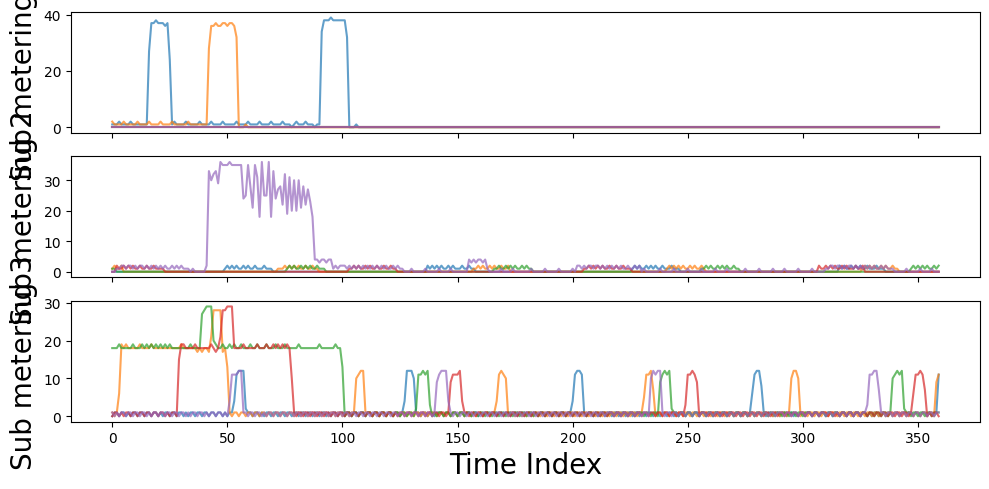

{'ID': 11, 'k': 3, 'Features': '1,0,2', 'm': 360, '#Matches': 3, 'Indices': '[4119, 77081, 73374, 2852]', 'max(dists)': 7.802, 'min(dists)': 7.033, 'med(dists)': 7.3, 'CE': 0.07, 'Score Unified': 0.066, 'Explained Var(%)': 1.13, 'P': 8.820940851428413e-107, 'p-value': 0.0, 'Sig_Hochber': True}
{'ID': 100, 'k': 2, 'Features': '1,0', 'm': 360, '#Matches': 11, 'Indices': '[57099, 49894, 48548, 58778, 42196, 50587, 41262, 960, 70014, 64984, 9124, 28260]', 'max(dists)': 8.112, 'min(dists)': 5.58, 'med(dists)': 7.58, 'CE': 0.057, 'Score Unified': 0.063, 'Explained Var(%)': 7.57, 'P': 5.7141447620833835e-53, 'p-value': 0.0, 'Sig_Hochber': True}


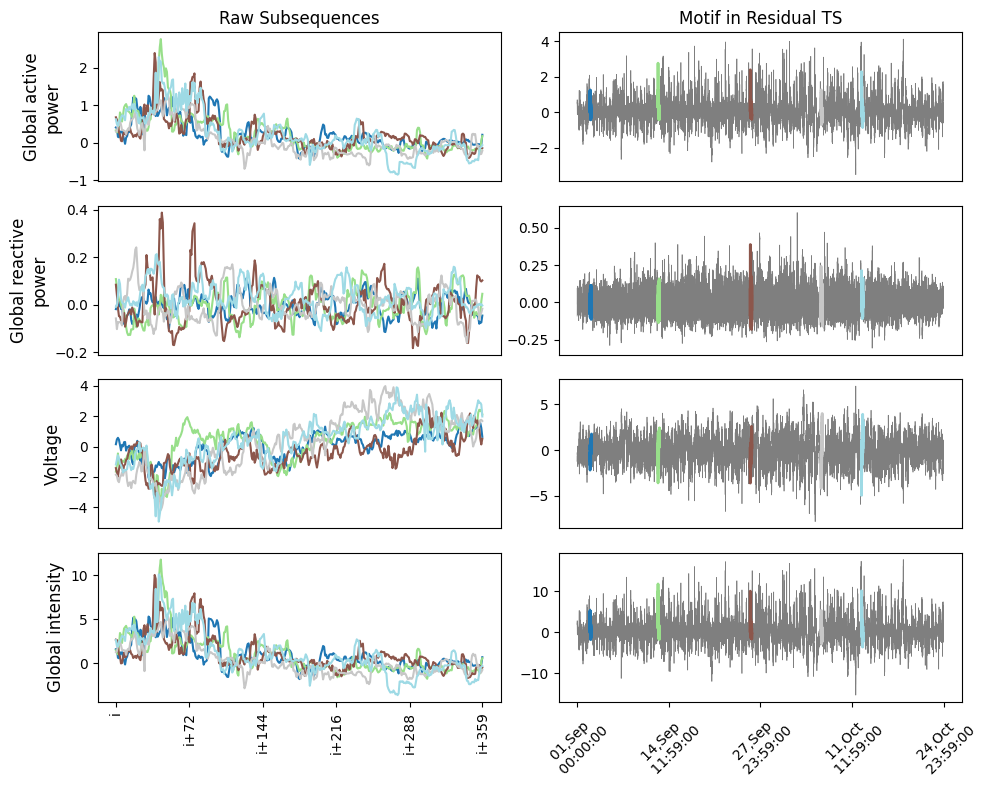

In [87]:
# Load motif statistics table
file_path = os.path.join(
    results_path,
    f"table_motifs_normalize={normalize}_min_neighbors={min_neighbors}_max_distance={max_distance}_cutoff={cutoff}_max_matches={max_matches}_max_motifs={max_motifs}.csv",
)
mp_stats_table = pd.read_csv(file_path)

# Extract unique subsequence lengths
subsequence_lengths = mp_stats_table["m"].unique()

# Time series data
ts = resids

# Loop over each subsequence length
for m in subsequence_lengths:
    logging.info(f"Motif length: {m}")

    # Filter motifs by current subsequence length
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)

    # Loop over each top motif
    for top_motif in top_motifs.to_dict(orient="records"):
        print(top_motif)
        # check if is motif 56
        if top_motif["ID"] != 56:
            continue

        # Parse dimensions and indices
        dimensions = sorted(map(int, top_motif["Features"].split(",")))
        indices = sorted(map(int, top_motif["Indices"].strip("[]").split(",")))

        # Extract feature names
        features = [resids.T.columns[dimension] for dimension in dimensions]

        # Add label feature to the list
        ts_list = [resids.T[feature].reset_index(drop=True) for feature in features]

        # Generate motif name
        motif_name = top_motif["ID"]

        # Create the figure and axes once, with 3 subplots for the submeters
        fig, ax = plt.subplots(figsize=(10, 5), nrows=3, sharex=True)

        # Loop over each index and plot the subsequences
        for indice in indices:
            subseq = labels.iloc[indice: indice + m]

            # Plot subsequences for each submeter in the same 3 subplots
            for i, feature in enumerate(labels.columns):
                ax[i].plot(subseq[feature].values, alpha=0.7)  # Plot with transparency to differentiate subsequences
                ax[i].set_ylabel(feature.replace("_", " "))  # Format the y-axis label for better readability

        # Set common x-axis labels and formatting
        ax[-1].set_xlabel("Time Index")  # Only set x-axis label on the bottom plot

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot (or save it, depending on your requirements)
        plt.show()

        features = [feature.replace("_", " ") for feature in features]

        # Plot and save the motif (assuming plot_motif function handles the time series plot)
        plot_motif(ts_list, features, m, indices, motif_name)


In [77]:
labels

,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,
2008-09-01 00:00:00,0.0,0.0,19.0
2008-09-01 00:01:00,0.0,0.0,19.0
2008-09-01 00:02:00,0.0,0.0,18.0
2008-09-01 00:03:00,0.0,0.0,19.0
2008-09-01 00:04:00,0.0,1.0,19.0
...,...,...,...
2008-10-24 23:55:00,0.0,0.0,0.0
2008-10-24 23:56:00,0.0,0.0,0.0
2008-10-24 23:57:00,0.0,0.0,0.0
